In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

 ## 용어정리

- 백테스트 : 특정 전략을 과거에 수행했을 때 얼마나 수익이 발생했는지 Historical 퍼포먼스 확인

  예시:) 자산배분전략백테스트, 저PER종목 백테스트, 우량주 백테스트 등


 
- 리밸런싱 : 특정 주기마다 포트폴리오 전체 가치에 대하여 각 자산(또는 종목)의 비중을 일정하게 맞춤
  
  예시:) 매 1년마다 미국채, 골드, 코스피, 현금 비중을 각각 40%, 20%, 30%, 10%가 되도록 매수 또는 매도
  

- 리밸런싱비용 : 자산을 매수 또는 매도하면서 bid ask spread, 양도소득세 등이 발생하는데 단순하게 여기서는 자산가치의 x%만큼 차감하자.


- riskfreerate : 무위험금리 (예금금리 등을 의미하며 여기서는 고정값을 가정하자)


- CapitalAnnualizedGrowthRate(CAGR) : 연율화된 자본수익률을 의미(여기서는 단순화를 위해 배당수익률을 제외하자)


- stdev : 연율화된 수익률 변동성(표준편차) = 월기준 수익률 표준편차 * sqrt(12)


- drawdown : 직전 1년 고점 대비하여 현재 가격 수준을 퍼센트로


- maximumdrawdown(MDD) : drawdown중 최고 손실


- sharp : (연율화 수익률 - 무위험수익률)/연율화표준편차

In [2]:
xlsxpath = r'C:\Users\ciiad\homework'         # 자산배분데이터.xlsx가 설치된 디렉토리
MyData = pd.read_excel(xlsxpath + '\\자산배분데이터.xlsx',index_col = 0, parse_dates = True)

In [3]:
MyData.head()

미국채10년(USD)   미국장기채(USD)     달러       골드(USD)  코스피(KRW)  \
날짜                                                                    
1995-01-31  8148.944644  7988.478904  786.7  10152.568760    925.56   
1995-02-28  8418.956591  8206.445586  786.0  10193.046186    885.69   
1995-03-31  8481.083234  8266.386424  771.5  10615.464453    931.78   
1995-04-30  8610.115492  8402.615600  761.8  10555.267255    897.00   
1995-05-31  9147.749900  9034.718979  760.1  10406.850026    882.50   

             코스피인버스(KRW)  S&P(USD)  
날짜                                  
1995-01-31  10000.000000    470.42  
1995-02-28  10430.766239    487.39  
1995-03-31   9887.964563    500.71  
1995-04-30  10257.046758    514.71  
1995-05-31  10422.851862    533.40

In [4]:
MyData.tail()

미국채10년(USD)    미국장기채(USD)      달러       골드(USD)  코스피(KRW)  \
날짜                                                                       
2022-08-31  31135.316241  40443.346972  1347.5  42898.575723   2472.05   
2022-09-30  29663.236372  37215.474209  1434.8  41659.266430   2155.49   
2022-10-31  29229.882522  35145.375034  1419.3  40916.450611   2293.61   
2022-11-30  30285.148766  37576.699568  1331.5  44388.056147   2472.53   
2022-12-31  29835.254693  36752.364774  1267.3  45688.946026   2236.40   

            코스피인버스(KRW)  S&P(USD)  
날짜                                 
2022-08-31   494.632016   3955.00  
2022-09-30   557.972447   3585.62  
2022-10-31   522.218556   3871.98  
2022-11-30   481.481314   4080.11  
2022-12-31   527.463439   3839.50

 # 문제 : 
 
 ## - 위의 데이터를 가지고 특정연월(YYYYMM1)부터 특정연월(YYYYMM2)까지 기간동안
 
 ## - 미국채10년, 장기미국채, 달러, 골드, 코스피, 코스피인버스, S&P에 각각 [x1, x2, x3, x4, x5, x6, x7] 비율로 투자했을 때 가치를 계산하는 함수를 만드시오.
 
 ## - 리밸런싱 주기를 변수로 넣어서 리밸런싱 주기를 조절 가능하게 만드시오

In [5]:
def Backtest_AssetAllocation(
    MyData : pd.core.frame.DataFrame,                    # 자산배분데이터
    startyyyymm : str,                                   # 백테스트 시작연월 YYYYMM (string)
    endyyyymm : str,                                     # 백테스트 종료연월 YYYYMM (string)
    rebalancefreq = 12,                                  # 리밸런싱 주기(투자비중 재조정주기) 단위 = 월
    WeightMatrix = [0.1, 0.4, 0.0, 0.1, 0.3, 0.0, 0.1],  # 자산별 비중 [미국채10년, 장기미국채, 달러, 금, 코스피, 코스피인버스, S&P 비중]
    rebalancefee = 0.00,                                 # 리밸런싱 비용(투자금액의 몇 퍼센트가 리벨런싱 수수료로 나가는지)
    initialmoney = 10000,                                # 초기투자금액
    riskfreerate = 0.012,                                # 무위험금리(예금금리 등 고정값을 가정)
    plotflag = True                                     # 시각화여부 Flag
    ) :
    '''
    - Variables -
    
    MyData : pd.core.frame.DataFrame,                    # 자산배분데이터
    
    startyyyymm : str,                                   # 백테스트 시작연월 'YYYYMM' (string)

    endyyyymm : str,                                     # 백테스트 종료연월 'YYYYMM' (string)
    
    rebalancefreq = 12,                                  # 리밸런싱 주기(투자비중 재조정주기) 단위 = 월
    
    WeightMatrix = [0.1, 0.4, 0.0, 0.1, 0.3, 0.0, 0.1],  # 자산별 비중 [미국채10년, 장기미국채, 달러, 금, 코스피, 코스피인버스, S&P 비중]
                                                         # 합이 1 초과이면 1 초과부분에 레버리지 비용으로 Risk Free만큼 발생
                                                         # 1 미만이면 나머지금액 무위험 금리로 투자 가정
                                                         
    rebalancefee = 0.00,                                 # 리밸런싱 비용(투자금액의 몇 퍼센트가 리벨런싱 수수료로 나가는지)
    
    initialmoney = 10000,                                # 초기투자금액
    
    riskfreerate = 0.012,                                # 무위험금리(예금금리 등 고정값을 가정)
    
    plotflag = True                                      # 시각화여부 Flag(False이면 시각화 안함)
    
    - Return -
        [0]: ResultData -> 포트폴리오 가치 (Monthly 포트폴리오 가치 데이터프레임을 리턴)
        [1]: ResultData2 -> 포트폴리오 분석 결과 (InitialValue, FinalValue, CAGR, stdev, MDD, Sharp, BestYear, WorstYear)
    
    - Examples -
        Backtest_AssetAllocation('200206', '202108', 12, [0.1, 0.4, 0.0, 0.1, 0.3, 0.0, 0.1], 0.0, 10000, 0.012, True)
    
    
    '''
    
    MyData.index = pd.to_datetime(MyData.index)
    DollarAssetNames = [i for i in MyData.columns if "USD"in i]
    wcash = 1 - sum(WeightMatrix)
    w = np.array(list(WeightMatrix) + [wcash]).reshape(1,-1)
    freq = int(rebalancefreq)
    DollarAsset = MyData[DollarAssetNames] * MyData[["달러"]].values
    NotDollarAsset = MyData[MyData.columns.drop(DollarAsset)]
    ConcatData = pd.concat([DollarAsset, NotDollarAsset],axis = 1)[MyData.columns]
    KRW_Cummulative_Return = ConcatData/ConcatData.iloc[0]
    RawData = KRW_Cummulative_Return[startyyyymm[:4] + '-' + startyyyymm[-2:]:endyyyymm[:4] + '-' + endyyyymm[-2:]]
    CashData = (pd.DataFrame([1.0] + [1.0 + riskfreerate * 1/12] * (len(RawData)-1),index = RawData.index, columns = ["현금"])).cumprod(0)
    RawData_includingcash = pd.concat([RawData, CashData],axis = 1)
    moneyvalue = initialmoney
    ResultData = pd.DataFrame([])
    i = 0
    while True :
        feerate = 0 if i == 0 else rebalancefee                                         # 첫달에는 비중 리밸런싱 없으므로 거래비용 없음

        PeriodData = RawData_includingcash.iloc[i*freq :(i+1) * freq + 1]
        PeriodReturn = PeriodData/PeriodData.iloc[0]                                     # 누적수익률
        Cummulative_PeriodReturn = (PeriodReturn * w * moneyvalue * (1-feerate)).sum(1) # 누적수익률 * weight * 투자금액 * (1-거래비용) 

        ###################################################
        # 마지막월 직전월까지 데이터 합치기               #
        # (마지막월까지 합치면 차기 시작월이랑 날짜 겹침) #
        ResultData = pd.concat([ResultData, Cummulative_PeriodReturn.iloc[:-1]])
        ###################################################

        ## 차기 투자금액
        moneyvalue = Cummulative_PeriodReturn.iloc[-1]

        i+= 1
        if PeriodData.index[-1] >= RawData_includingcash.index[-1] : 
            ## 반복문 끝나면 맨 마지막월 데이터도 합쳐줘야함
            ResultData = pd.concat([ResultData, Cummulative_PeriodReturn.iloc[-1:]])    
            break

    ResultData.columns = ["PortValue"]
    finalvalue = ResultData["PortValue"].iloc[-1]
    AnnualPerformance = ResultData.resample("Y").apply(lambda x : x.iloc[-1]/x.iloc[0] -1)
    t = (ResultData.index[-1] - ResultData.index[0]).days/365
    CapitalAnnualizedGrowthRate = (ResultData["PortValue"].iloc[-1]/ResultData["PortValue"].iloc[0])**(1/t) - 1
    stdev = ResultData["PortValue"].pct_change().iloc[1:].std() * np.sqrt(12)
    drawdown = ((ResultData["PortValue"].iloc[12:]-ResultData["PortValue"].rolling(12).max().iloc[12:])/ResultData["PortValue"].rolling(12).max().iloc[12:])
    maximumdrawdown = drawdown.min()
    bestyear = AnnualPerformance["PortValue"].max()
    worstyear = AnnualPerformance["PortValue"].min()
    sharp = (CapitalAnnualizedGrowthRate - riskfreerate)/stdev
    ResultData2 = pd.DataFrame([[initialmoney, finalvalue, CapitalAnnualizedGrowthRate, 
                                 stdev, maximumdrawdown, sharp, bestyear, worstyear]], 
                                 columns = ["InitialValue","FinalValue","CAGR","stdev","MDD","Sharp","BestYear","WorstYear"],
                                 index = ["Result"])

    if plotflag == True :
        plt.figure(figsize = (16,16 ))
        plt.subplot(3,1,1)
        plt.ylabel('My Portfolio Value', fontsize = 15)
        plt.plot(ResultData[ResultData.columns[0]], label = 'my_portfolio_value')
        plt.legend(loc = 'best')

        plt.figure(figsize = (16,16))
        plt.subplot(3,1,2)
        plt.ylabel('Draw Down', fontsize = 15)
        plt.plot(drawdown, color = 'black')

        plt.subplot(3,1,3)
        plt.ylabel('Annual Return', fontsize = 16)
        ind = np.arange(len(AnnualPerformance))
        kospi_ret_Y = RawData["코스피(KRW)"].resample("Y").apply(lambda x : x.iloc[-1]/x.iloc[0] -1)
        real_index = list(pd.Series(kospi_ret_Y.index).apply(lambda x : x.year))
        plt.xticks(ind, real_index, rotation = 'vertical')
        plt.bar(ind , AnnualPerformance["PortValue"], label = 'Ann_Ret' , width = 0.3 , color = 'b')
        plt.bar(ind+0.15 , kospi_ret_Y, label = 'KOSPI', width= 0.3, color = 'orange')
        
    return ResultData, ResultData2

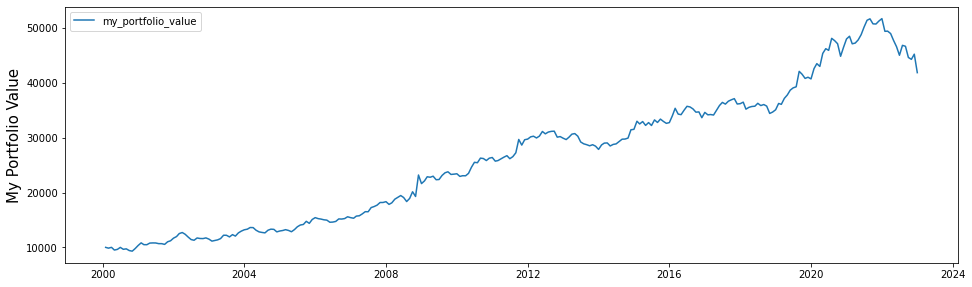

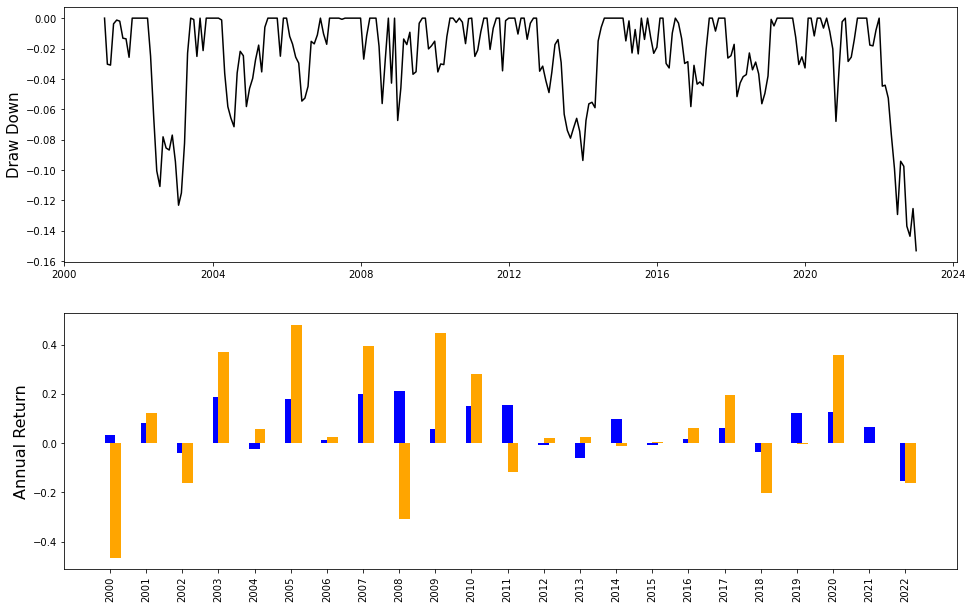

In [6]:
Data1, Data2 = Backtest_AssetAllocation(MyData = MyData,
                                        startyyyymm = '200001', 
                                        endyyyymm = '202212', 
                                        rebalancefreq = 12, 
                                        WeightMatrix = [0.1, 0.4, 0.0, 0.1, 0.3, 0.0, 0.1], 
                                        rebalancefee = 0.0, 
                                        initialmoney = 10000, 
                                        riskfreerate = 0.012, 
                                        plotflag = True)

In [7]:
Data1

PortValue
2000-01-31  10000.000000
2000-02-29   9854.408064
2000-03-31  10004.777258
2000-04-30   9510.317932
2000-05-31   9631.796637
...                  ...
2022-08-31  46654.366608
2022-09-30  44616.536632
2022-10-31  44272.883343
2022-11-30  45215.424798
2022-12-31  41847.812603

[276 rows x 1 columns]

In [8]:
Data2

InitialValue    FinalValue      CAGR     stdev       MDD     Sharp  \
Result         10000  41847.812603  0.064413  0.094137 -0.153132  0.556771   

        BestYear  WorstYear  
Result  0.212388  -0.152572

 ## 6개월마다 리벨런싱하는 경우

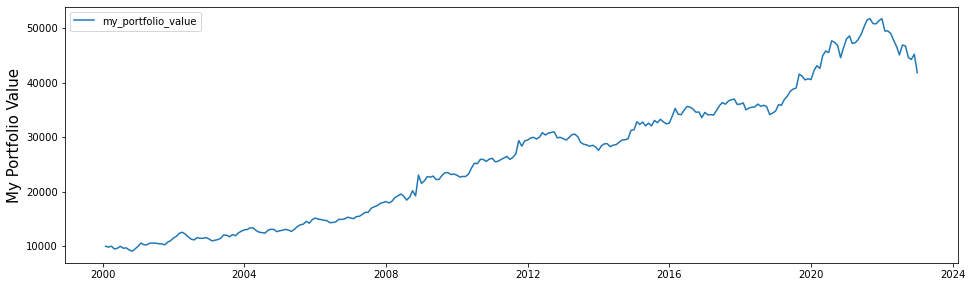

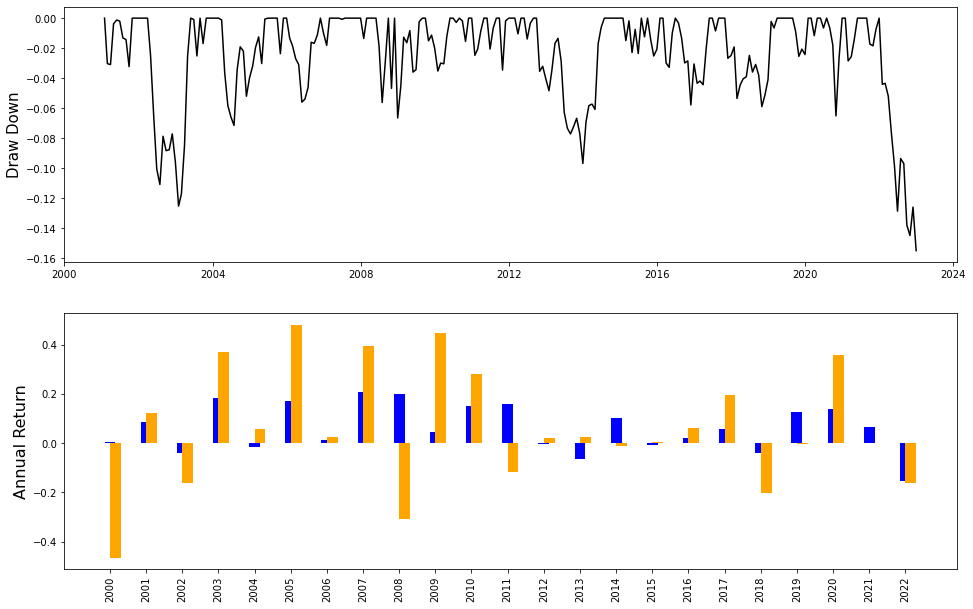

In [9]:
Data3, Data4 = Backtest_AssetAllocation(MyData = MyData,
                                        startyyyymm = '200001', 
                                        endyyyymm = '202212', 
                                        rebalancefreq = 6, 
                                        WeightMatrix = [0.1, 0.4, 0.0, 0.1, 0.3, 0.0, 0.1], 
                                        rebalancefee = 0.0, 
                                        initialmoney = 10000, 
                                        riskfreerate = 0.012, 
                                        plotflag = True)

In [10]:
Data3

PortValue
2000-01-31  10000.000000
2000-02-29   9854.408064
2000-03-31  10004.777258
2000-04-30   9510.317932
2000-05-31   9631.796637
...                  ...
2022-08-31  46695.479843
2022-09-30  44572.179008
2022-10-31  44217.424933
2022-11-30  45195.357333
2022-12-31  41796.014094

[276 rows x 1 columns]

In [11]:
Data4

InitialValue    FinalValue      CAGR     stdev       MDD     Sharp  \
Result         10000  41796.014094  0.064355  0.093677 -0.154959  0.558892   

        BestYear  WorstYear  
Result  0.208748    -0.1544